In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import itertools
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.api import add_constant
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from pandas.tseries.holiday import USFederalHolidayCalendar
import warnings
warnings.filterwarnings('ignore')


# CLUSTER 1

13:02:57 - cmdstanpy - INFO - Chain [1] start processing
13:02:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:02:57 - cmdstanpy - INFO - Chain [1] start processing
13:02:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.75it/s]13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:58 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.39it/s]
13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.43it/s]13:02:58 - cmdstanpy - INFO - Chain [1] start processing
13:02:59 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.31it/s]
13:02:59 - cmdstanpy - INFO - Chain [1] start processing
13:02:59 

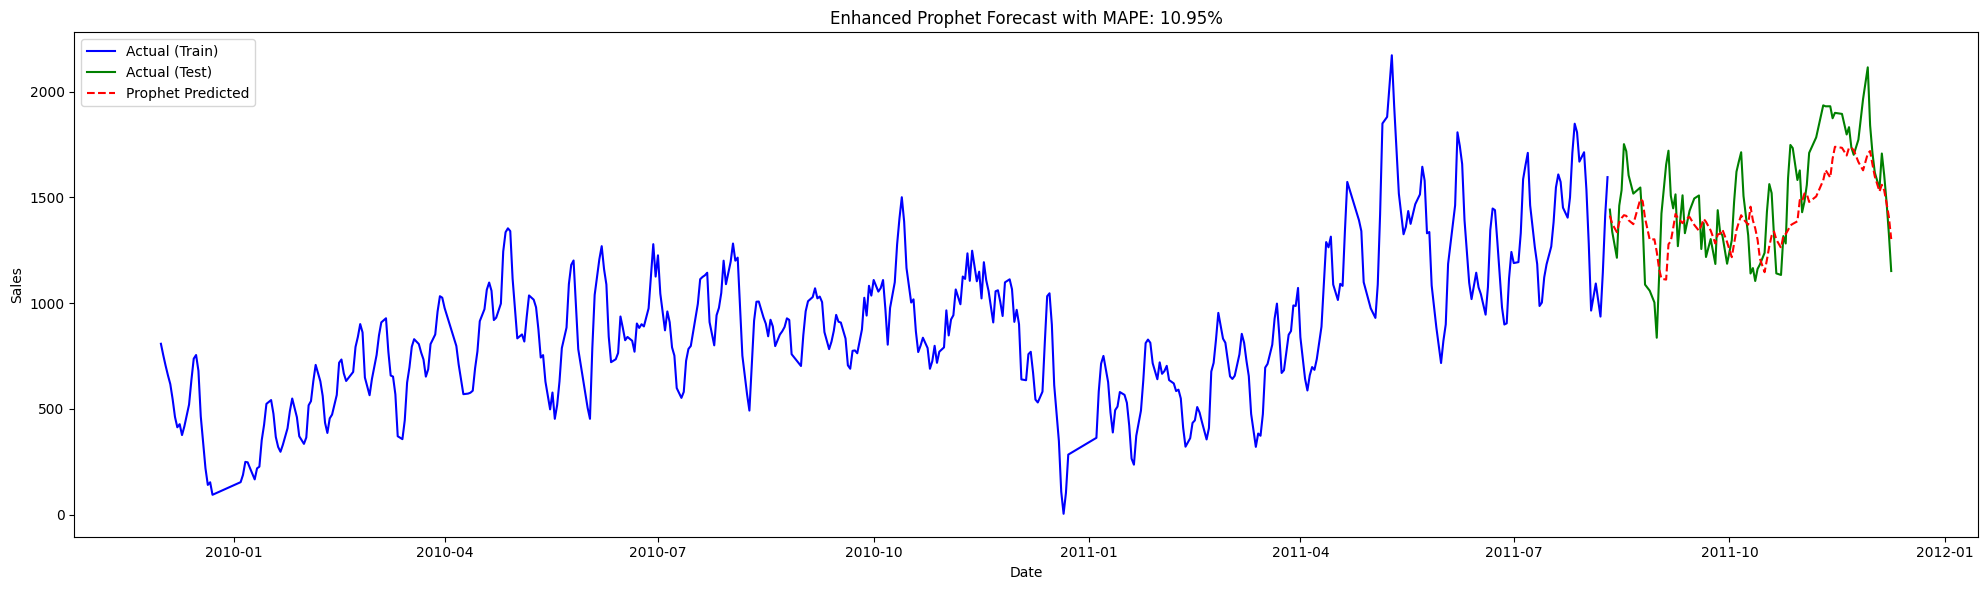


MAPE for Each Region:
  Region 1: 15.44%
  Region 2: 8.28%
  Region 3: 11.69%
  Region 4: 8.53%


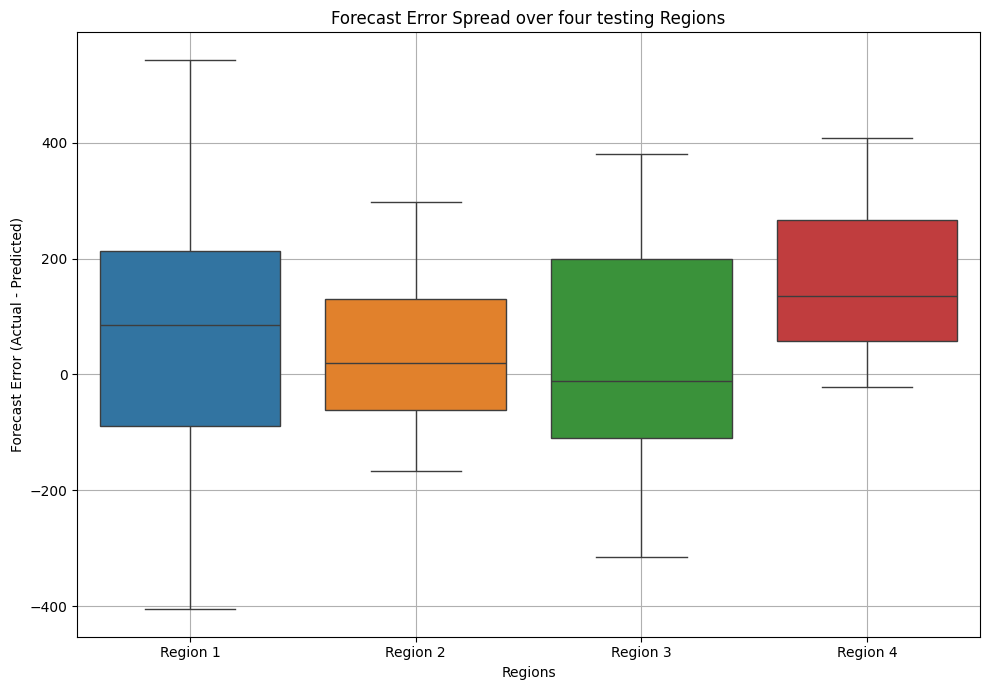


Best Hyperparameters: {'changepoint_prior_scale': 0.02, 'seasonality_mode': 'additive', 'fourier_order': 5}
Cross-Validated MAPE: 17.72%
Test MAPE: 10.95%


In [27]:

df = pd.read_csv("Cluster files//cluster_1.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['Quantity', 'Price'])
df['Sales'] = df['Quantity'] * df['Price']

# Aggregate daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

# Outlier removal
Q1, Q3 = daily_sales['y'].quantile([0.25, 0.75])
IQR = Q3 - Q1
daily_sales = daily_sales[(daily_sales['y'] >= (Q1 - 1.5 * IQR)) & (daily_sales['y'] <= (Q3 + 1.5 * IQR))]

# Savitzky-Golay smoothing
daily_sales['y'] = savgol_filter(daily_sales['y'], window_length=9, polyorder=2)

# Feature engineering
daily_sales['month'] = daily_sales['ds'].dt.month
daily_sales['day_of_week'] = daily_sales['ds'].dt.dayofweek
daily_sales['rolling_7'] = daily_sales['y'].rolling(7).mean().fillna(method='bfill')

# Add logistic growth boundaries
daily_sales['cap'] = daily_sales['y'].max() * 1.1
daily_sales['floor'] = daily_sales['y'].min() * 0.9

# Add US holiday dates
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=daily_sales['ds'].min(), end=daily_sales['ds'].max())
holidays_df = pd.DataFrame({'ds': holidays, 'holiday': 'us_holiday'})

# ------------------- Train/Test Split -------------------
test_size = 90
train_data = daily_sales.iloc[:-test_size].copy()
test_data = daily_sales.iloc[-test_size:].copy()

# ------------------- Hyperparameter Tuning -------------------
param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.02],
    'seasonality_mode': ['additive'],
    'fourier_order': [5, 8]
}

def tune_prophet_with_cv(train_data, param_grid):
    best_mape = np.inf
    best_model = None
    best_params = None

    for cps in param_grid['changepoint_prior_scale']:
        for sm in param_grid['seasonality_mode']:
            for fourier in param_grid['fourier_order']:
                try:
                    m = Prophet(
                        growth='logistic',
                        daily_seasonality=True,
                        changepoint_prior_scale=cps,
                        seasonality_mode=sm,
                        holidays=holidays_df
                    )
                    m.add_seasonality(name='yearly', period=365, fourier_order=fourier)
                    m.add_regressor('month')
                    m.add_regressor('day_of_week')
                    m.add_regressor('rolling_7')

                    m.fit(train_data)

                    df_cv = cross_validation(m, initial='450 days', period='45 days', horizon='90 days')
                    df_p = performance_metrics(df_cv, metrics=['mape'])
                    current_mape = df_p['mape'].mean() * 100

                    if current_mape < best_mape:
                        best_mape = current_mape
                        best_model = m
                        best_params = {
                            'changepoint_prior_scale': cps,
                            'seasonality_mode': sm,
                            'fourier_order': fourier
                        }
                except:
                    continue

    return best_model, best_params, best_mape

# Train best model
best_model, best_params, best_cv_mape = tune_prophet_with_cv(train_data, param_grid)

# ------------------- Forecasting -------------------
test_data['month'] = test_data['ds'].dt.month
test_data['day_of_week'] = test_data['ds'].dt.dayofweek
test_data['rolling_7'] = test_data['y'].rolling(7).mean().fillna(method='bfill')
test_data['cap'] = train_data['cap'].max()
test_data['floor'] = train_data['floor'].min()

future = test_data[['ds', 'month', 'day_of_week', 'rolling_7', 'cap', 'floor']]
forecast = best_model.predict(future)

y_true = test_data['y'].values
y_pred = forecast['yhat'].values
final_mape = mean_absolute_percentage_error(y_true, y_pred) * 100

# ------------------- Forecast Plot -------------------
plt.figure(figsize=(20, 6))
plt.plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual (Test)', color='green')
plt.plot(test_data['ds'], forecast['yhat'], label='Prophet Predicted', color='red', linestyle='--')
plt.title(f"Enhanced Prophet Forecast with MAPE: {final_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- Region-wise Boxplot -------------------
regions = 4
days_per_region = test_size // regions
error_lists = []

print("\nMAPE for Each Region:")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region
    y_true_region = y_true[start:end]
    y_pred_region = y_pred[start:end]
    region_errors = y_true_region - y_pred_region
    error_lists.append(region_errors)

    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

plt.figure(figsize=(10, 7))
sns.boxplot(data=error_lists)
plt.title("Forecast Error Spread over four testing Regions")
plt.xlabel("Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- Summary -------------------
print(f"\nBest Hyperparameters: {best_params}")
print(f"Cross-Validated MAPE: {best_cv_mape:.2f}%")
print(f"Test MAPE: {final_mape:.2f}%")

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 819ms/step - loss: 0.1032 - val_loss: 0.0525 - learning_rate: 3.0000e-04
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.0230 - val_loss: 0.0529 - learning_rate: 3.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 629ms/step - loss: 0.0161 - val_loss: 0.0164 - learning_rate: 3.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 642ms/step - loss: 0.0116 - val_loss: 0.0177 - learning_rate: 3.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - loss: 0.0099 - val_loss: 0.0212 - learning_rate: 3.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - loss: 0.0089 - val_loss: 0.0167 - learning_rate: 3.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - loss: 0.0099 - val_loss: 0.0171 - learning_rate: 3.0000e-04
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 685ms/step - loss: 0.0091 - val_loss: 0.0170 - learning_rate: 3.0000e-04
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 724ms/step - loss: 0.0080 - val_loss: 0.0155 - learning_rate: 3.

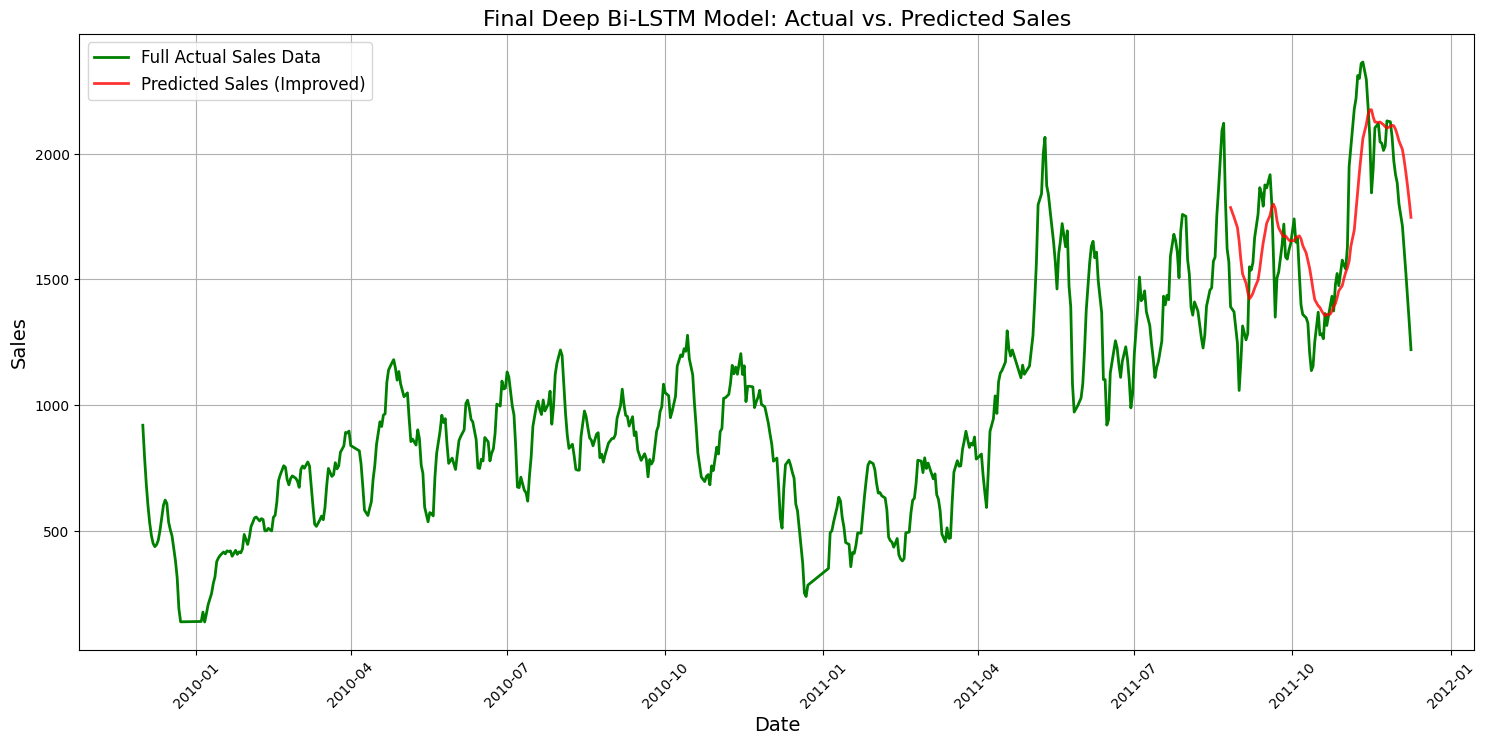

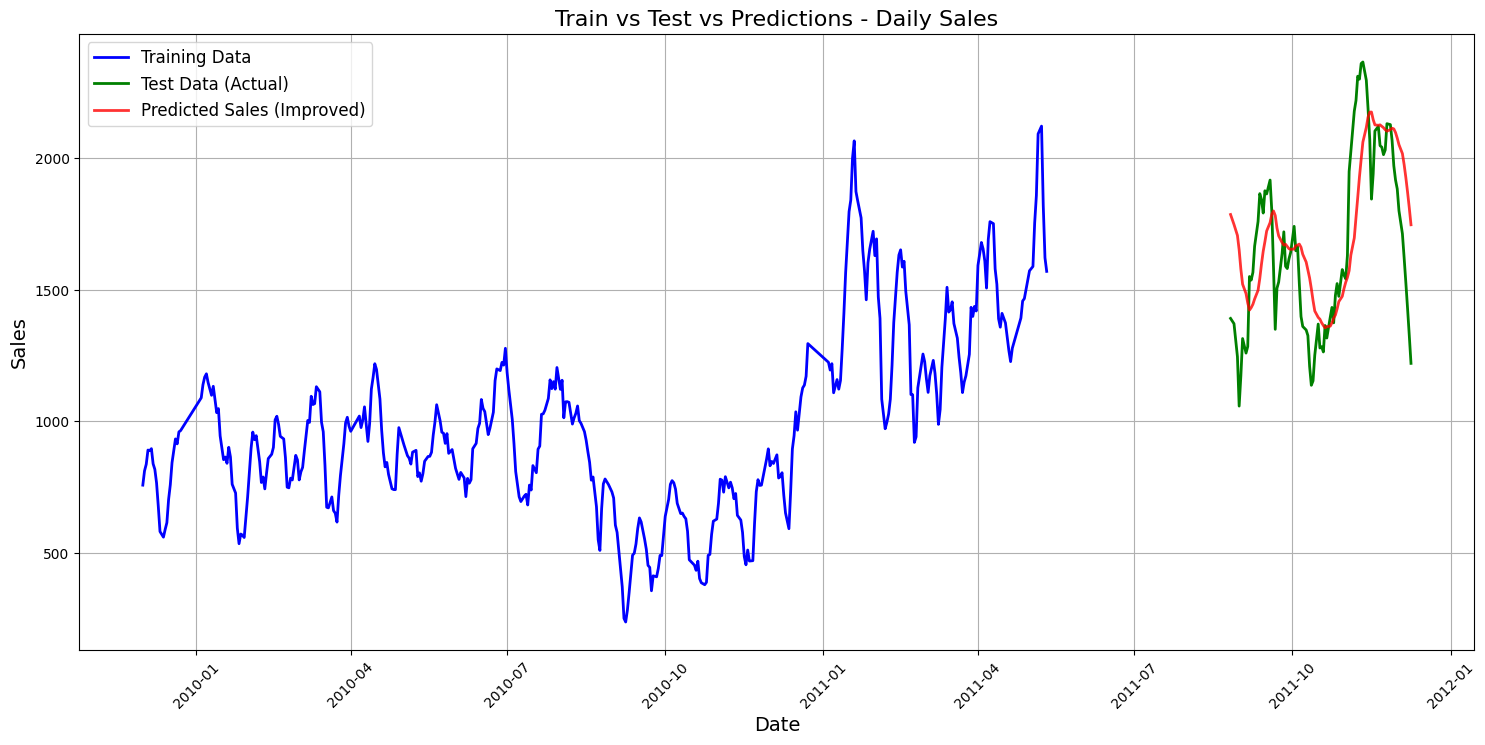

MAPE for Each Region (LSTM Model):
Region 1: 17.76%
Region 2: 11.32%
Region 3: 9.11%
Region 4: 9.21%


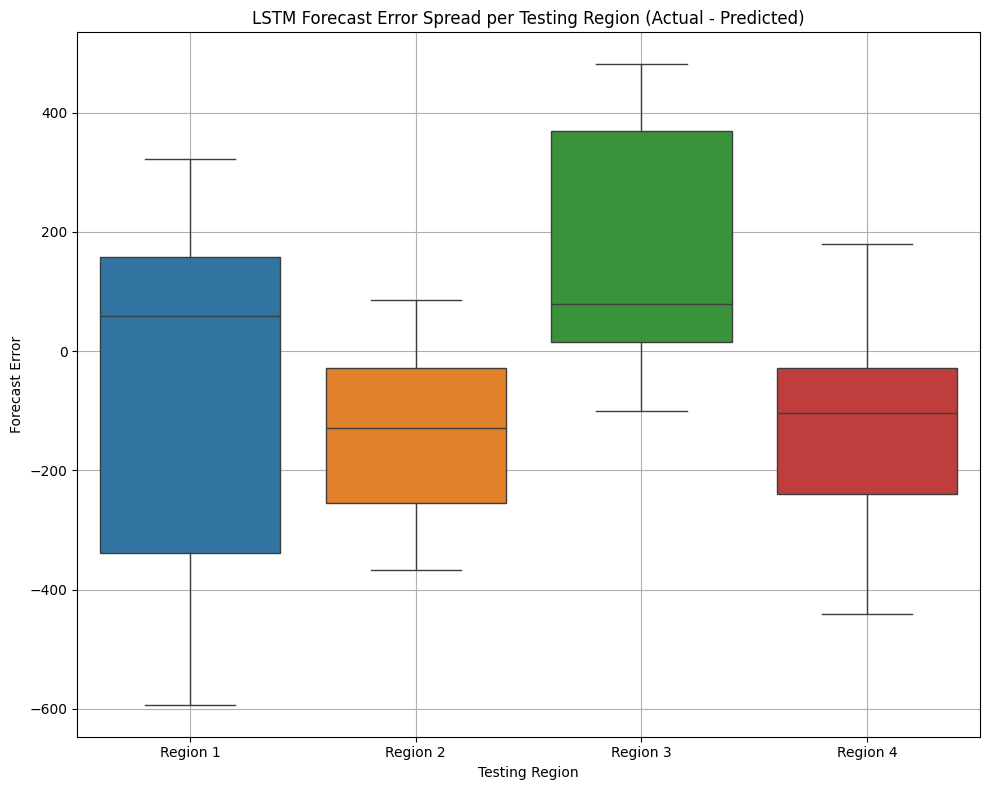

In [18]:
df = pd.read_csv("Cluster files//cluster_1.csv")  # Change to actual dataset file

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# *Step 2: Pre-Processing*
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]  # Remove Refunds (Negative Sales)
df['Sales'] = df['Quantity'] * df['Price']  # Compute Total Sales

# Remove Outliers using IQR Method
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sales'] >= (Q1 - 1.5 * IQR)) & (df['Sales'] <= (Q3 + 1.5 * IQR))]

# Aggregate Sales Data by Date
daily_sales_lstm = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales_lstm.columns = ['ds', 'y']
daily_sales_lstm['ds'] = pd.to_datetime(daily_sales_lstm['ds'])

# Apply Savitzky-Golay Smoothing (Window Size: 15, Polynomial Order: 2)
daily_sales_lstm['y'] = savgol_filter(daily_sales_lstm['y'], window_length=15, polyorder=2)

# Normalize sales values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales_lstm['y'] = scaler.fit_transform(daily_sales_lstm[['y']])

# *Step 3: Function to Create Sequences*
def create_sequences(data, time_steps=90):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array
sales_data = daily_sales_lstm[['y']].values

# Define sequence length (look-back period)
time_steps = 90  # 90 days lookback

# Generate sequences
X, y = create_sequences(sales_data, time_steps)

# Reshape X to fit LSTM input requirements
X = X.reshape((X.shape[0], X.shape[1], 1))

# *Step 4: Train-Test Split (Last 90 Days for Testing)*
test_size = 90  # Use last 90 days for testing
train_size = len(X) - test_size  # Everything before the last 90 days is training data

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# *Step 5: Optimized Bi-LSTM Model*
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(time_steps, 1)),
    Dropout(0.15),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
    Dropout(0.15),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(1, activation="linear")
])

# *Step 6: Optimized Learning Rate & Regularization*
optimizer = Adam(learning_rate=0.0003)  # Lower learning rate for stability

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# *Step 7: Implement Early Stopping & Learning Rate Scheduler*
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00005)

# Train model
history = model.fit(X_train, y_train,
                    epochs = 20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_reduction],
                    verbose=1)

# *Step 8: Predict on Test Data*
y_pred = model.predict(X_test)

# *Step 9: Fix Shape Mismatch*
y_pred = y_pred[:len(y_test)]  # Ensure predictions match test set length

# *Step 10: Reverse Scaling*
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# *Step 11: Compute Error Metrics*
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
accuracy = 100 - mape

# Print Metrics
print(f"MAPE: {mape:.2f}%")

# *Step 12: Plot Optimized Predictions with Actual Dates*
plt.figure(figsize=(18,8))

# Extract proper date range for test data
date_range = daily_sales_lstm['ds'].iloc[-len(y_test_original):]

# Plot full actual sales data
plt.plot(daily_sales_lstm['ds'], scaler.inverse_transform(daily_sales_lstm[['y']]),
         label="Full Actual Sales Data", color='g', linewidth=2)

# Plot predictions on test set
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Final Deep Bi-LSTM Model: Actual vs. Predicted Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# *Step 13: Train vs Test vs Predictions*
plt.figure(figsize=(18,8))

# Training Data
plt.plot(daily_sales_lstm['ds'][:len(y_train)], scaler.inverse_transform(y_train.reshape(-1,1)),
         label="Training Data", color='blue', linewidth=2)

# Test Data
plt.plot(date_range, y_test_original, label="Test Data (Actual)", color='g', linewidth=2)

# Predictions
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Train vs Test vs Predictions - Daily Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()


regions = 4
days_per_region = 90 // regions  # 90 test days divided into 5 regions
lstm_mape_list = []
lstm_error_lists = []

print("MAPE for Each Region (LSTM Model):")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = y_test_original[start:end].flatten()  # Convert to 1D array
    y_pred_region = y_pred_original[start:end].flatten()  # Convert to 1D array

    mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    lstm_mape_list.append(mape)
    lstm_error_lists.append(list(y_true_region - y_pred_region))  # Ensure it's a 1D list

    print(f"Region {i+1}: {mape:.2f}%")

plt.figure(figsize=(10, 8))
sns.boxplot(data=lstm_error_lists)
plt.title("LSTM Forecast Error Spread per Testing Region (Actual - Predicted)")
plt.xlabel("Testing Region")
plt.ylabel("Forecast Error")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

GLM MAPE: 15.352772107619863 %


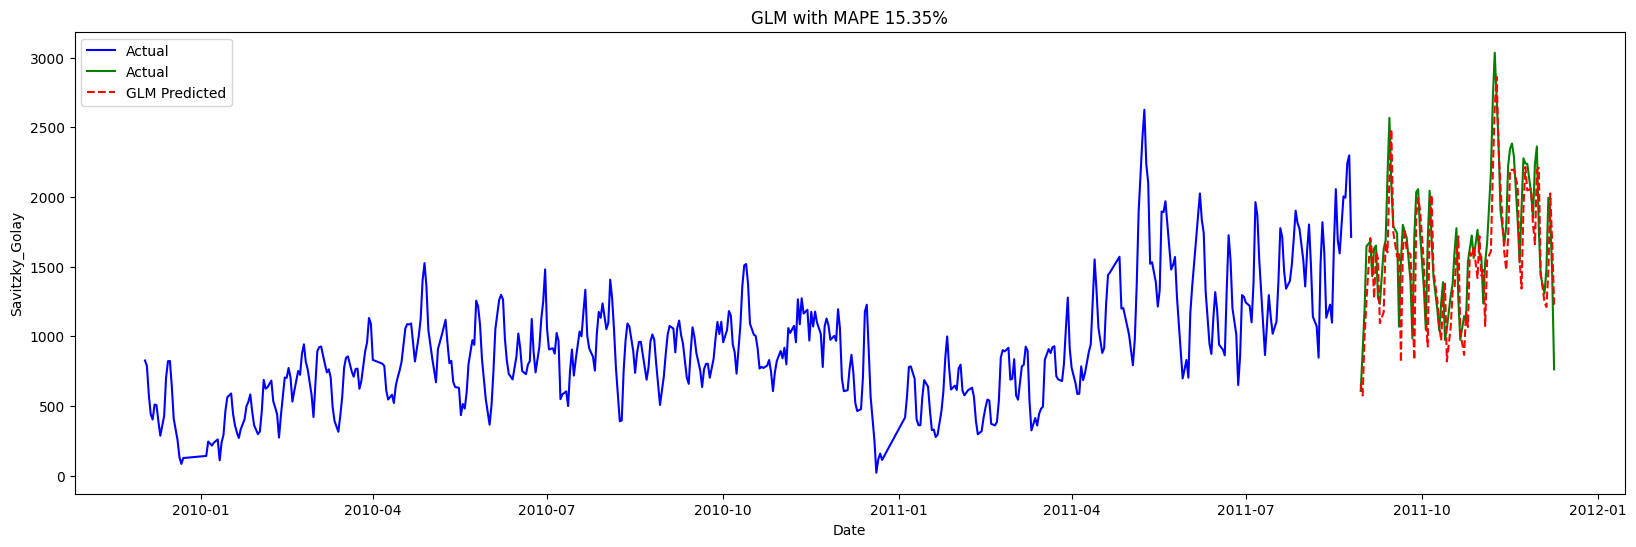

  Region 1: 16.85%
  Region 2: 16.48%
  Region 3: 14.00%
  Region 4: 14.08%


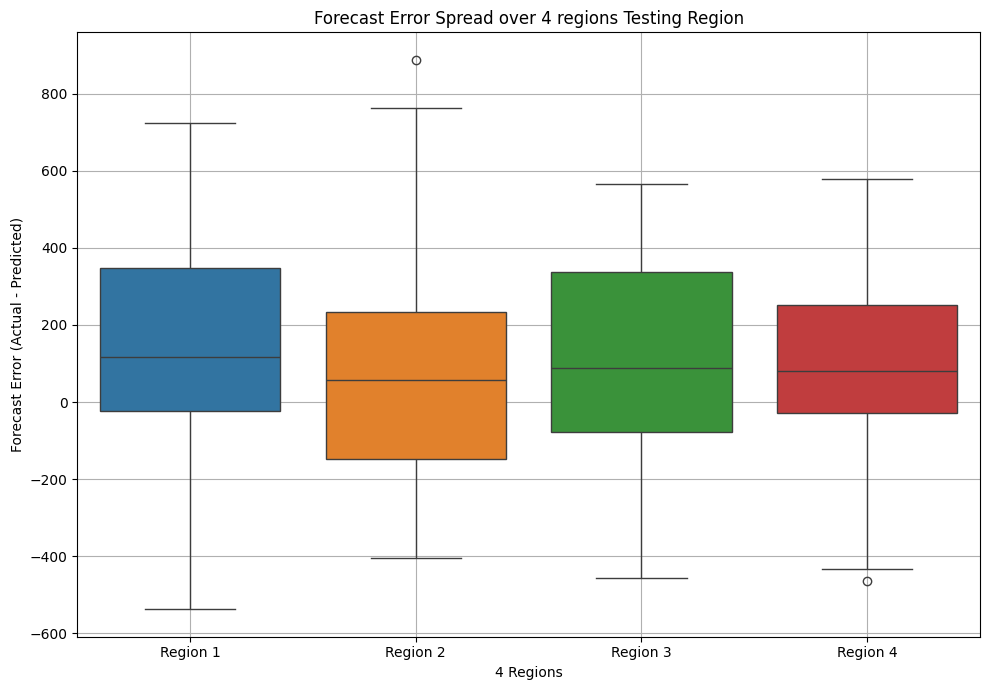

In [19]:
pd.options.mode.chained_assignment = None
cluster_data = pd.read_csv("Cluster files//cluster_1.csv")
cluster_data
# Assuming the data is stored in a DataFrame called `df`
# Convert InvoiceDate to datetime format
cluster_data['InvoiceDate'] = pd.to_datetime(cluster_data['InvoiceDate'])

# Extract the date part
cluster_data['Date'] = cluster_data['InvoiceDate'].dt.date

# Calculate total sales for each transaction
cluster_data['TotalSales'] = cluster_data['Quantity'] * cluster_data['Price']

# Aggregate total sales by date
sales_by_date = cluster_data.groupby('Date')['TotalSales'].sum().reset_index()

# Rename columns for clarity
sales_by_date.columns = ['Date', 'TotalSales']

# Display the result
daily_sales = sales_by_date.copy()
# Resetting Date as index
df_daily = pd.DataFrame(daily_sales)
df_daily['Savitzky_Golay'] = savgol_filter(df_daily['TotalSales'], window_length=7, polyorder=2)
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.set_index('Date', inplace=True)
test_size = 90
train = df_daily.iloc[:-test_size]
test = df_daily.iloc[-test_size:]
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Split into train (all but last 30 days) and test (last 30 days)
test_size = 90
X_train = daily_sales.iloc[:-test_size]
y_train = daily_sales.iloc[-test_size:]

# Create lagged features
train['Lag1'] = train['Savitzky_Golay'].shift(1)
train['Lag2'] = train['Savitzky_Golay'].shift(2)
train.dropna(inplace=True)

# Prepare data for GLM
X_train = add_constant(train[['Lag1', 'Lag2']])
y_train = train['Savitzky_Golay']

# Fit GLM model
# glm_model = GLM(y_train, X_train, family=sm.families.Gaussian()).fit()
glm_model = GLM(y_train, X_train, family=sm.families.Gaussian(), alpha=0.1).fit()

# Create lagged features for test data
test['Lag1'] = test['Savitzky_Golay'].shift(1)
test['Lag2'] = test['Savitzky_Golay'].shift(2)
test.dropna(inplace=True)

# Predict for the test period
X_test = add_constant(test[['Lag1', 'Lag2']])
glm_pred = glm_model.predict(X_test)

# Calculate MAPE
glm_mape = mean_absolute_percentage_error(test['Savitzky_Golay'], glm_pred) * 100
print("GLM MAPE:", glm_mape, "%")
plt.figure(figsize=(20, 6))
plt.plot(train['Date'], train['Savitzky_Golay'], label='Actual', color='blue')
plt.plot(test['Date'], test['Savitzky_Golay'], label='Actual', color='green')
plt.plot(test['Date'], glm_pred, label='GLM Predicted', color='red', linestyle='--')
plt.title(f"GLM with MAPE {glm_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Savitzky_Golay')
plt.legend()
plt.show()

# Parameters
regions = 4
days_per_region = len(test) // regions  # Ensure it's divided properly, e.g., should be 15 if len(test) == 90

# Compute error (Actual - Predicted) per region
error_lists = []
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = test['Savitzky_Golay'].iloc[start:end]
    y_pred_region = glm_pred[start:end]
    errors = y_true_region - y_pred_region
    error_lists.append(errors)
    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

# Convert error_lists to DataFrame for easier plotting with Seaborn
error_df = pd.DataFrame(error_lists).T  # Transpose to make each region a column

# Plotting
plt.figure(figsize=(10, 7))
sns.boxplot(data=error_df)
plt.title("Forecast Error Spread over 4 regions Testing Region")
plt.xlabel("4 Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()



# CLUSTER 5

13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:04:21 - cmdstanpy - INFO - Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.43it/s]13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.30it/s]
13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.36it/s]13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.17it/s]
13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:23 

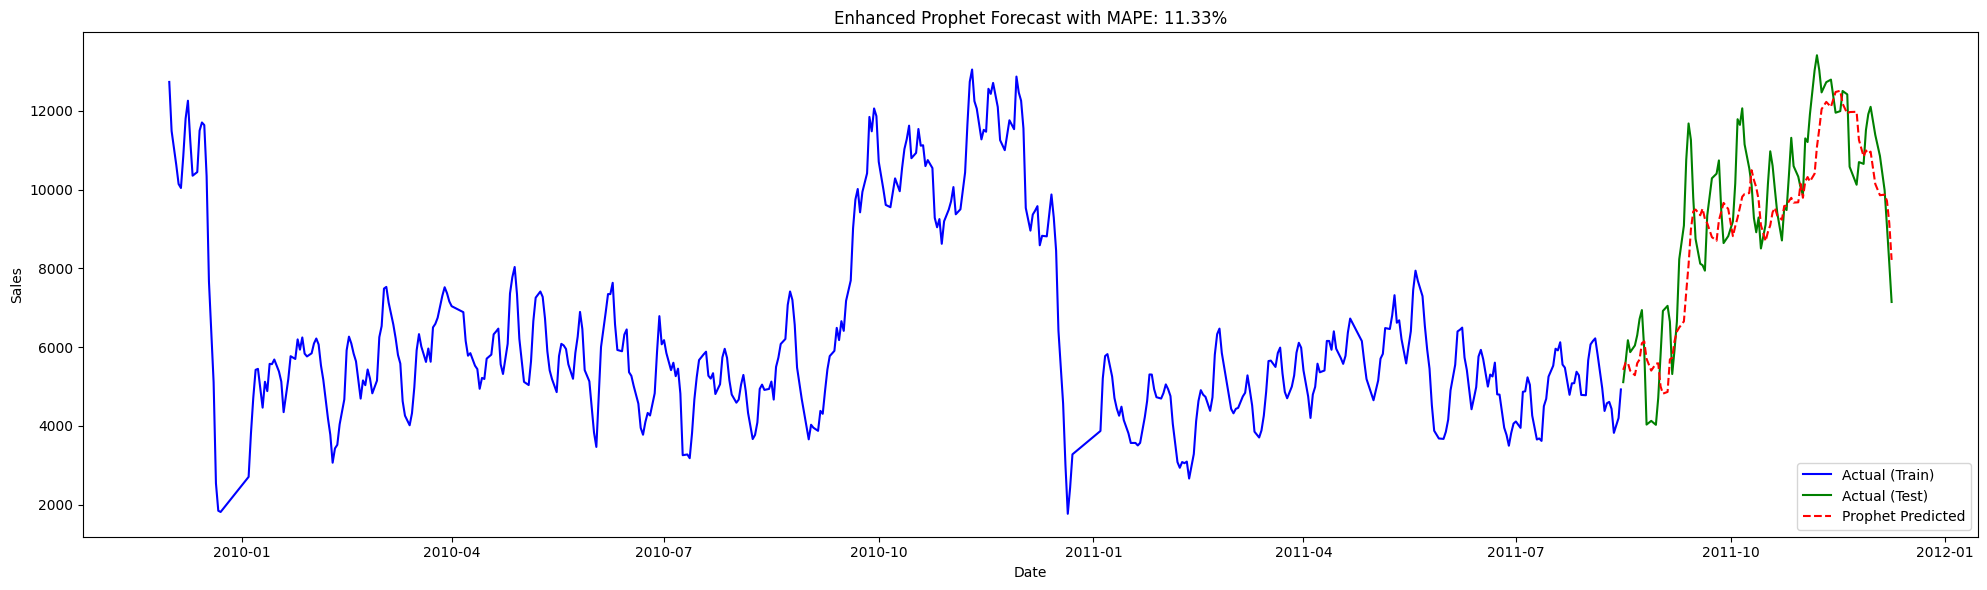


MAPE for Each Region:
  Region 1: 16.39%
  Region 2: 13.68%
  Region 3: 6.85%
  Region 4: 8.20%


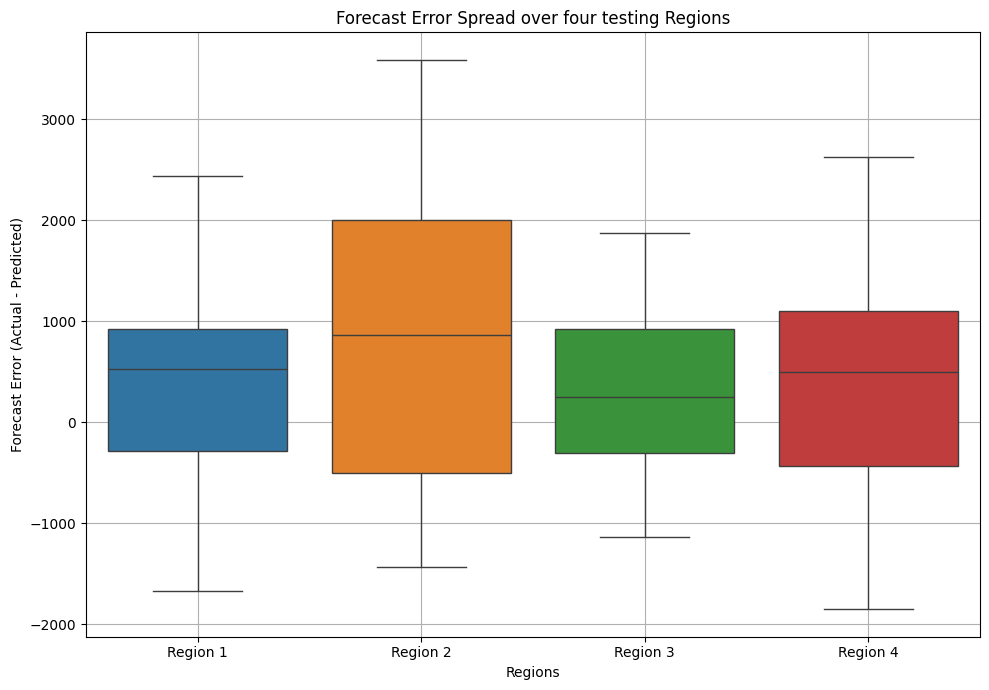


Best Hyperparameters: {'changepoint_prior_scale': 0.02, 'seasonality_mode': 'additive', 'fourier_order': 5}
Cross-Validated MAPE: 16.04%
Test MAPE: 11.33%


In [29]:

df = pd.read_csv("Cluster files//cluster_5.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['Quantity', 'Price'])
df['Sales'] = df['Quantity'] * df['Price']

# Aggregate daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

# Outlier removal
Q1, Q3 = daily_sales['y'].quantile([0.25, 0.75])
IQR = Q3 - Q1
daily_sales = daily_sales[(daily_sales['y'] >= (Q1 - 1.5 * IQR)) & (daily_sales['y'] <= (Q3 + 1.5 * IQR))]

# Savitzky-Golay smoothing
daily_sales['y'] = savgol_filter(daily_sales['y'], window_length=9, polyorder=2)

# Feature engineering
daily_sales['month'] = daily_sales['ds'].dt.month
daily_sales['day_of_week'] = daily_sales['ds'].dt.dayofweek
daily_sales['rolling_7'] = daily_sales['y'].rolling(7).mean().fillna(method='bfill')

# Add logistic growth boundaries
daily_sales['cap'] = daily_sales['y'].max() * 1.1
daily_sales['floor'] = daily_sales['y'].min() * 0.9

# Add US holiday dates
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=daily_sales['ds'].min(), end=daily_sales['ds'].max())
holidays_df = pd.DataFrame({'ds': holidays, 'holiday': 'us_holiday'})

# ------------------- Train/Test Split -------------------
test_size = 90
train_data = daily_sales.iloc[:-test_size].copy()
test_data = daily_sales.iloc[-test_size:].copy()

# ------------------- Hyperparameter Tuning -------------------
param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.02],
    'seasonality_mode': ['additive'],
    'fourier_order': [5, 8]
}

def tune_prophet_with_cv(train_data, param_grid):
    best_mape = np.inf
    best_model = None
    best_params = None

    for cps in param_grid['changepoint_prior_scale']:
        for sm in param_grid['seasonality_mode']:
            for fourier in param_grid['fourier_order']:
                try:
                    m = Prophet(
                        growth='logistic',
                        daily_seasonality=True,
                        changepoint_prior_scale=cps,
                        seasonality_mode=sm,
                        holidays=holidays_df
                    )
                    m.add_seasonality(name='yearly', period=365, fourier_order=fourier)
                    m.add_regressor('month')
                    m.add_regressor('day_of_week')
                    m.add_regressor('rolling_7')

                    m.fit(train_data)

                    df_cv = cross_validation(m, initial='450 days', period='45 days', horizon='90 days')
                    df_p = performance_metrics(df_cv, metrics=['mape'])
                    current_mape = df_p['mape'].mean() * 100

                    if current_mape < best_mape:
                        best_mape = current_mape
                        best_model = m
                        best_params = {
                            'changepoint_prior_scale': cps,
                            'seasonality_mode': sm,
                            'fourier_order': fourier
                        }
                except:
                    continue

    return best_model, best_params, best_mape

# Train best model
best_model, best_params, best_cv_mape = tune_prophet_with_cv(train_data, param_grid)

# ------------------- Forecasting -------------------
test_data['month'] = test_data['ds'].dt.month
test_data['day_of_week'] = test_data['ds'].dt.dayofweek
test_data['rolling_7'] = test_data['y'].rolling(7).mean().fillna(method='bfill')
test_data['cap'] = train_data['cap'].max()
test_data['floor'] = train_data['floor'].min()

future = test_data[['ds', 'month', 'day_of_week', 'rolling_7', 'cap', 'floor']]
forecast = best_model.predict(future)

y_true = test_data['y'].values
y_pred = forecast['yhat'].values
final_mape = mean_absolute_percentage_error(y_true, y_pred) * 100

# ------------------- Forecast Plot -------------------
plt.figure(figsize=(20, 6))
plt.plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual (Test)', color='green')
plt.plot(test_data['ds'], forecast['yhat'], label='Prophet Predicted', color='red', linestyle='--')
plt.title(f"Enhanced Prophet Forecast with MAPE: {final_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- Region-wise Boxplot -------------------
regions = 4
days_per_region = test_size // regions
error_lists = []

print("\nMAPE for Each Region:")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region
    y_true_region = y_true[start:end]
    y_pred_region = y_pred[start:end]
    region_errors = y_true_region - y_pred_region
    error_lists.append(region_errors)

    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

plt.figure(figsize=(10, 7))
sns.boxplot(data=error_lists)
plt.title("Forecast Error Spread over four testing Regions")
plt.xlabel("Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- Summary -------------------
print(f"\nBest Hyperparameters: {best_params}")
print(f"Cross-Validated MAPE: {best_cv_mape:.2f}%")
print(f"Test MAPE: {final_mape:.2f}%")

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 839ms/step - loss: 0.1098 - val_loss: 0.0192 - learning_rate: 3.0000e-04
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 644ms/step - loss: 0.0267 - val_loss: 0.0714 - learning_rate: 3.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - loss: 0.0170 - val_loss: 0.0160 - learning_rate: 3.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step - loss: 0.0139 - val_loss: 0.0193 - learning_rate: 3.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 600ms/step - loss: 0.0128 - val_loss: 0.0143 - learning_rate: 3.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 552ms/step - loss: 0.0102 - val_loss: 0.0148 - learning_rate: 3.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - loss: 0.0095 - val_loss: 0.0132 - learning_rate: 3.0000e-04
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - loss: 0.0077 - val_loss: 0.0131 - learning_rate: 3.0000e-04
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - loss: 0.0069 - val_loss: 0.0074 - learning_rate: 3.

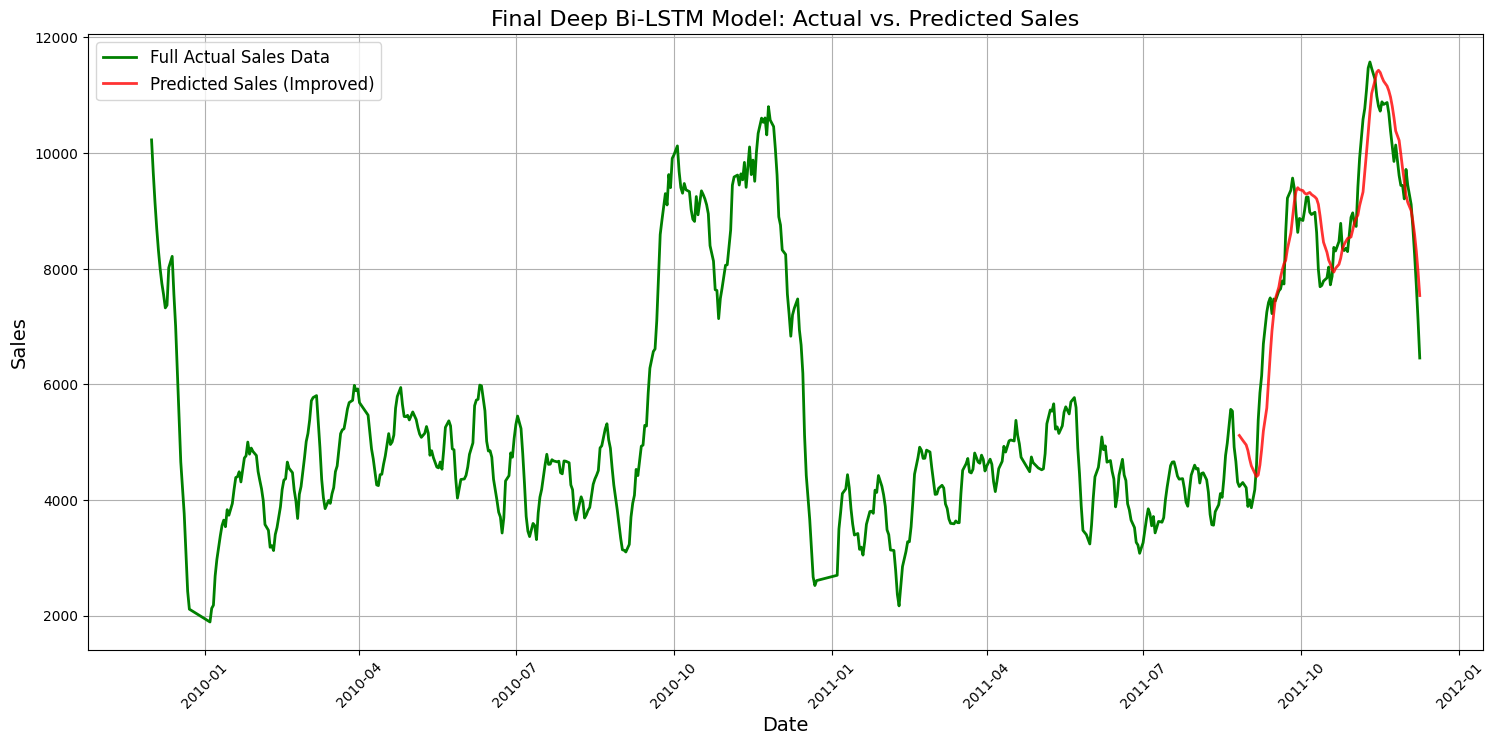

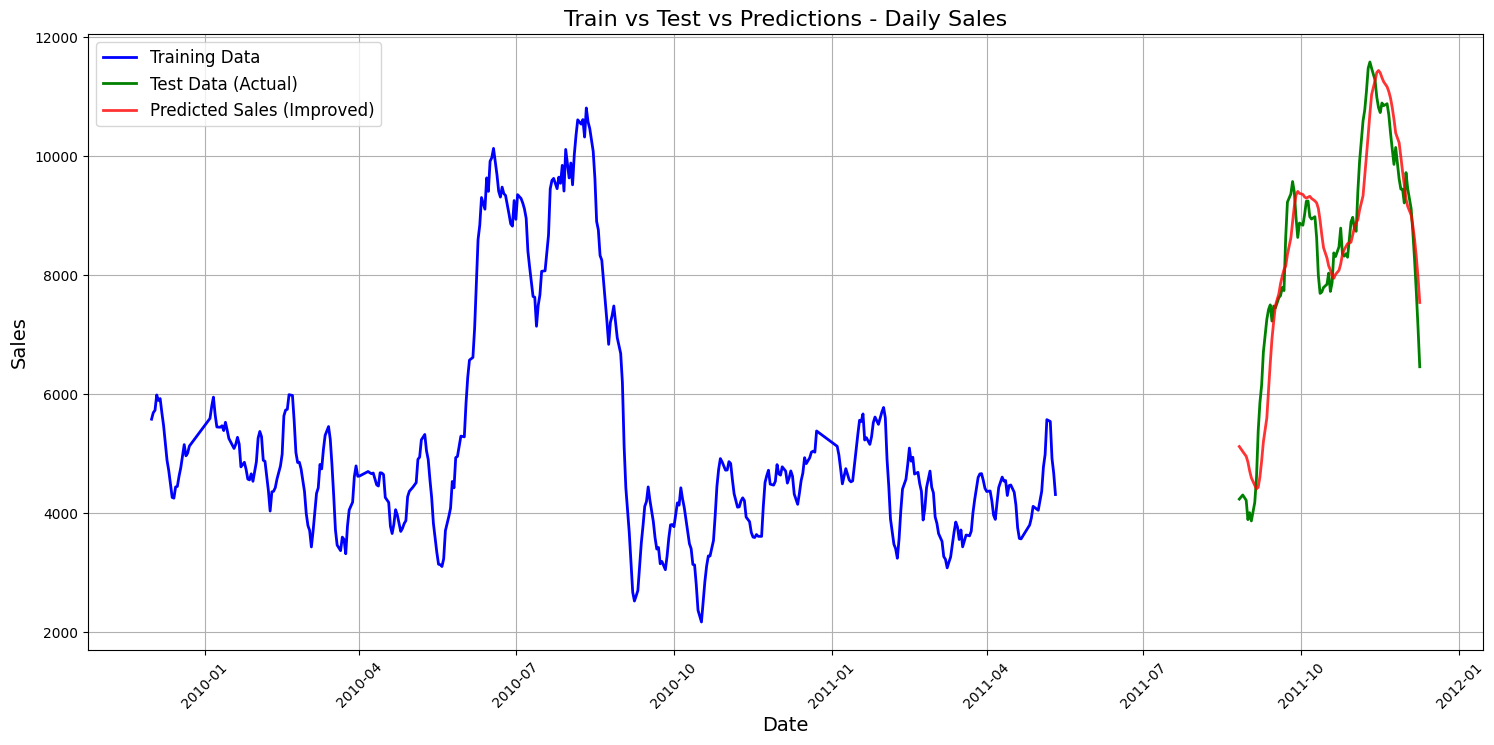

MAPE for Each Region (LSTM Model):
Region 1: 12.86%
Region 2: 6.26%
Region 3: 4.88%
Region 4: 4.22%


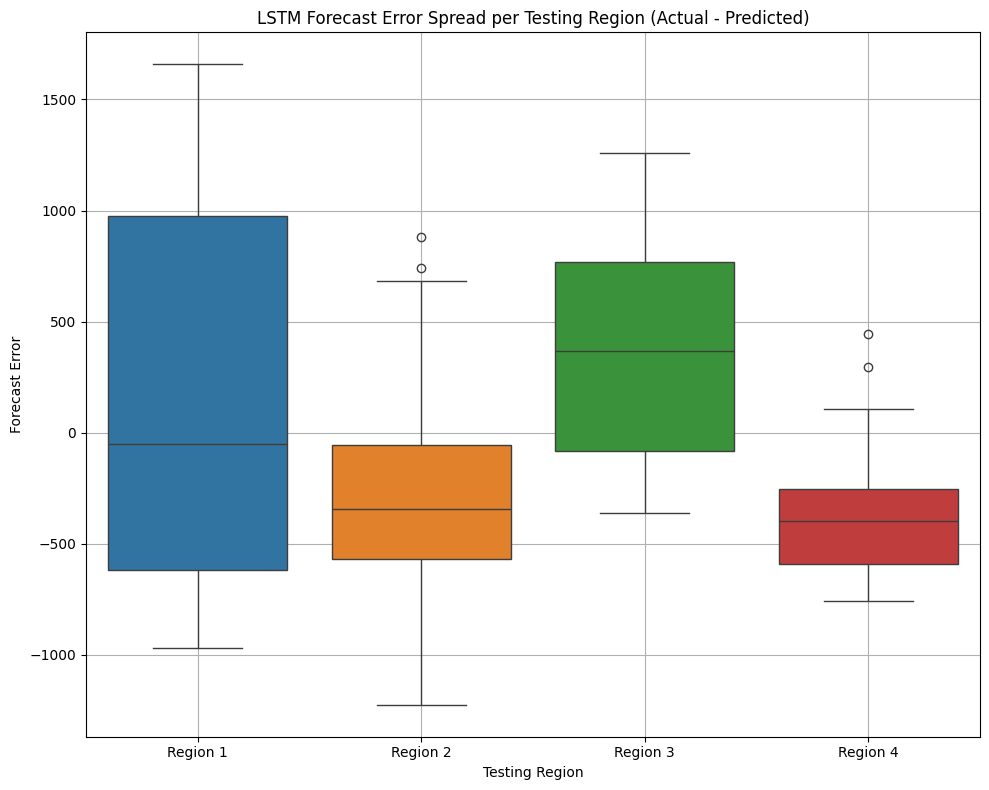

In [20]:
df = pd.read_csv("Cluster files//cluster_5.csv")  # Change to actual dataset file

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# *Step 2: Pre-Processing*
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]  # Remove Refunds (Negative Sales)
df['Sales'] = df['Quantity'] * df['Price']  # Compute Total Sales

# Remove Outliers using IQR Method
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sales'] >= (Q1 - 1.5 * IQR)) & (df['Sales'] <= (Q3 + 1.5 * IQR))]

# Aggregate Sales Data by Date
daily_sales_lstm = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales_lstm.columns = ['ds', 'y']
daily_sales_lstm['ds'] = pd.to_datetime(daily_sales_lstm['ds'])

# Apply Savitzky-Golay Smoothing (Window Size: 15, Polynomial Order: 2)
daily_sales_lstm['y'] = savgol_filter(daily_sales_lstm['y'], window_length=15, polyorder=2)

# Normalize sales values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales_lstm['y'] = scaler.fit_transform(daily_sales_lstm[['y']])

# *Step 3: Function to Create Sequences*
def create_sequences(data, time_steps=90):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array
sales_data = daily_sales_lstm[['y']].values

# Define sequence length (look-back period)
time_steps = 90  # 90 days lookback

# Generate sequences
X, y = create_sequences(sales_data, time_steps)

# Reshape X to fit LSTM input requirements
X = X.reshape((X.shape[0], X.shape[1], 1))

# *Step 4: Train-Test Split (Last 90 Days for Testing)*
test_size = 90  # Use last 90 days for testing
train_size = len(X) - test_size  # Everything before the last 90 days is training data

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# *Step 5: Optimized Bi-LSTM Model*
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(time_steps, 1)),
    Dropout(0.15),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
    Dropout(0.15),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(1, activation="linear")
])

# *Step 6: Optimized Learning Rate & Regularization*
optimizer = Adam(learning_rate=0.0003)  # Lower learning rate for stability

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# *Step 7: Implement Early Stopping & Learning Rate Scheduler*
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00005)

# Train model
history = model.fit(X_train, y_train,
                    epochs = 20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_reduction],
                    verbose=1)

# *Step 8: Predict on Test Data*
y_pred = model.predict(X_test)

# *Step 9: Fix Shape Mismatch*
y_pred = y_pred[:len(y_test)]  # Ensure predictions match test set length

# *Step 10: Reverse Scaling*
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# *Step 11: Compute Error Metrics*
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
accuracy = 100 - mape

# Print Metrics
print(f"MAPE: {mape:.2f}%")

# *Step 12: Plot Optimized Predictions with Actual Dates*
plt.figure(figsize=(18,8))

# Extract proper date range for test data
date_range = daily_sales_lstm['ds'].iloc[-len(y_test_original):]

# Plot full actual sales data
plt.plot(daily_sales_lstm['ds'], scaler.inverse_transform(daily_sales_lstm[['y']]),
         label="Full Actual Sales Data", color='g', linewidth=2)

# Plot predictions on test set
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Final Deep Bi-LSTM Model: Actual vs. Predicted Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# *Step 13: Train vs Test vs Predictions*
plt.figure(figsize=(18,8))

# Training Data
plt.plot(daily_sales_lstm['ds'][:len(y_train)], scaler.inverse_transform(y_train.reshape(-1,1)),
         label="Training Data", color='blue', linewidth=2)

# Test Data
plt.plot(date_range, y_test_original, label="Test Data (Actual)", color='g', linewidth=2)

# Predictions
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Train vs Test vs Predictions - Daily Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()


regions = 4
days_per_region = 90 // regions  # 90 test days divided into 5 regions
lstm_mape_list = []
lstm_error_lists = []

print("MAPE for Each Region (LSTM Model):")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = y_test_original[start:end].flatten()  # Convert to 1D array
    y_pred_region = y_pred_original[start:end].flatten()  # Convert to 1D array

    mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    lstm_mape_list.append(mape)
    lstm_error_lists.append(list(y_true_region - y_pred_region))  # Ensure it's a 1D list

    print(f"Region {i+1}: {mape:.2f}%")

plt.figure(figsize=(10, 8))
sns.boxplot(data=lstm_error_lists)
plt.title("LSTM Forecast Error Spread per Testing Region (Actual - Predicted)")
plt.xlabel("Testing Region")
plt.ylabel("Forecast Error")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

GLM MAPE: 10.680938912222256 %


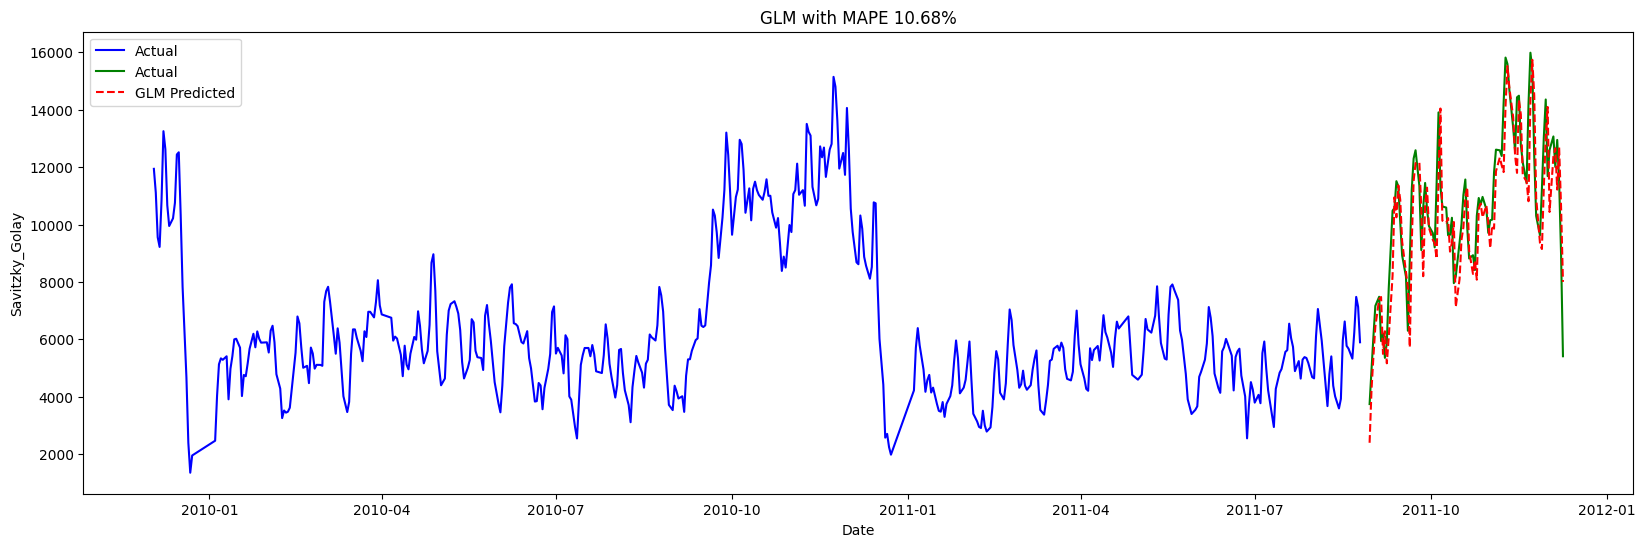

  Region 1: 13.54%
  Region 2: 10.54%
  Region 3: 6.20%
  Region 4: 12.44%


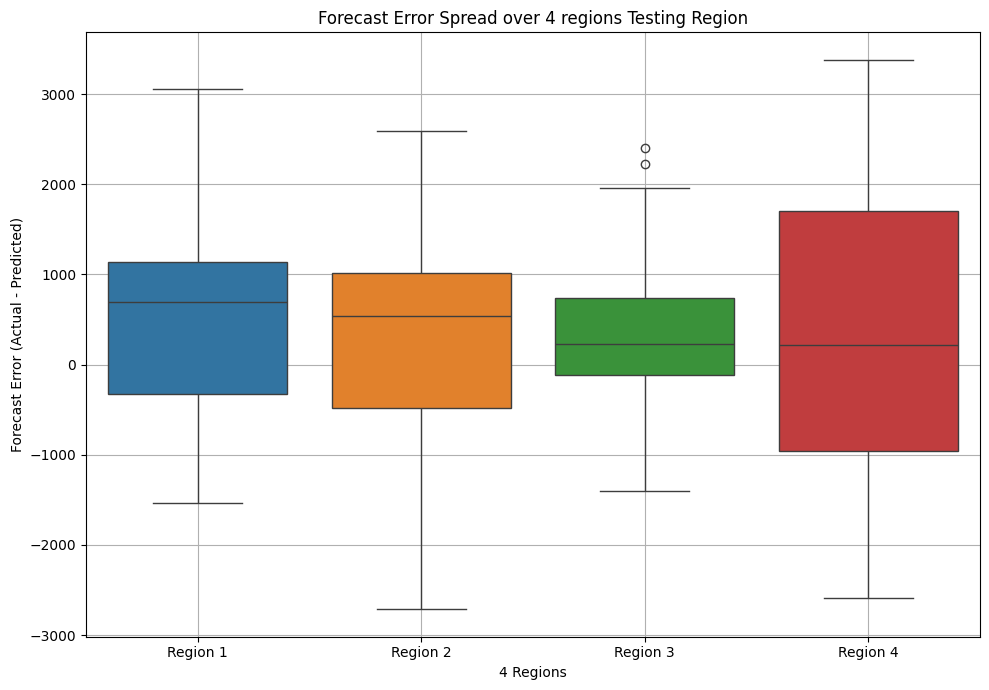

In [21]:
import pandas as pd
cluster_data = pd.read_csv("Cluster files//cluster_5.csv")
cluster_data
# Assuming the data is stored in a DataFrame called `df`
# Convert InvoiceDate to datetime format
cluster_data['InvoiceDate'] = pd.to_datetime(cluster_data['InvoiceDate'])

# Extract the date part
cluster_data['Date'] = cluster_data['InvoiceDate'].dt.date

# Calculate total sales for each transaction
cluster_data['TotalSales'] = cluster_data['Quantity'] * cluster_data['Price']

# Aggregate total sales by date
sales_by_date = cluster_data.groupby('Date')['TotalSales'].sum().reset_index()

# Rename columns for clarity
sales_by_date.columns = ['Date', 'TotalSales']

# Display the result
daily_sales = sales_by_date.copy()
# Resetting Date as index
df_daily = pd.DataFrame(daily_sales)
df_daily['Savitzky_Golay'] = savgol_filter(df_daily['TotalSales'], window_length=7, polyorder=2)
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.set_index('Date', inplace=True)
test_size = 90
train = df_daily.iloc[:-test_size]
test = df_daily.iloc[-test_size:]
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Split into train (all but last 30 days) and test (last 30 days)
test_size = 90
X_train = daily_sales.iloc[:-test_size]
y_train = daily_sales.iloc[-test_size:]

# Create lagged features
train['Lag1'] = train['Savitzky_Golay'].shift(1)
train['Lag2'] = train['Savitzky_Golay'].shift(2)
train.dropna(inplace=True)

# Prepare data for GLM
X_train = add_constant(train[['Lag1', 'Lag2']])
y_train = train['Savitzky_Golay']

# Fit GLM model
# glm_model = GLM(y_train, X_train, family=sm.families.Gaussian()).fit()
glm_model = GLM(y_train, X_train, family=sm.families.Gaussian(), alpha=0.1).fit()

# Create lagged features for test data
test['Lag1'] = test['Savitzky_Golay'].shift(1)
test['Lag2'] = test['Savitzky_Golay'].shift(2)
test.dropna(inplace=True)

# Predict for the test period
X_test = add_constant(test[['Lag1', 'Lag2']])
glm_pred = glm_model.predict(X_test)

# Calculate MAPE
glm_mape = mean_absolute_percentage_error(test['Savitzky_Golay'], glm_pred) * 100
print("GLM MAPE:", glm_mape, "%")
plt.figure(figsize=(20, 6))
plt.plot(train['Date'], train['Savitzky_Golay'], label='Actual', color='blue')
plt.plot(test['Date'], test['Savitzky_Golay'], label='Actual', color='green')
plt.plot(test['Date'], glm_pred, label='GLM Predicted', color='red', linestyle='--')
plt.title(f"GLM with MAPE {glm_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Savitzky_Golay')
plt.legend()
plt.show()

# Parameters
regions = 4
days_per_region = len(test) // regions  # Ensure it's divided properly, e.g., should be 15 if len(test) == 90

# Compute error (Actual - Predicted) per region
error_lists = []
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = test['Savitzky_Golay'].iloc[start:end]
    y_pred_region = glm_pred[start:end]
    errors = y_true_region - y_pred_region
    error_lists.append(errors)
    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

# Convert error_lists to DataFrame for easier plotting with Seaborn
error_df = pd.DataFrame(error_lists).T  # Transpose to make each region a column

# Plotting
plt.figure(figsize=(10, 7))
sns.boxplot(data=error_df)
plt.title("Forecast Error Spread over 4 regions Testing Region")
plt.xlabel("4 Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()



# CLUSTER 7

13:04:50 - cmdstanpy - INFO - Chain [1] start processing
13:04:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.56it/s]13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.44it/s]
13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:04:51 - cmdstanpy - INFO - Chain [1] start processing
13:04:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.85it/s]13:04:52 - cmdstanpy - INFO - Chain [1] start processing
13:04:52 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.85it/s]
13:04:52 - cmdstanpy - INFO - Chain [1] start processing
13:04:52 

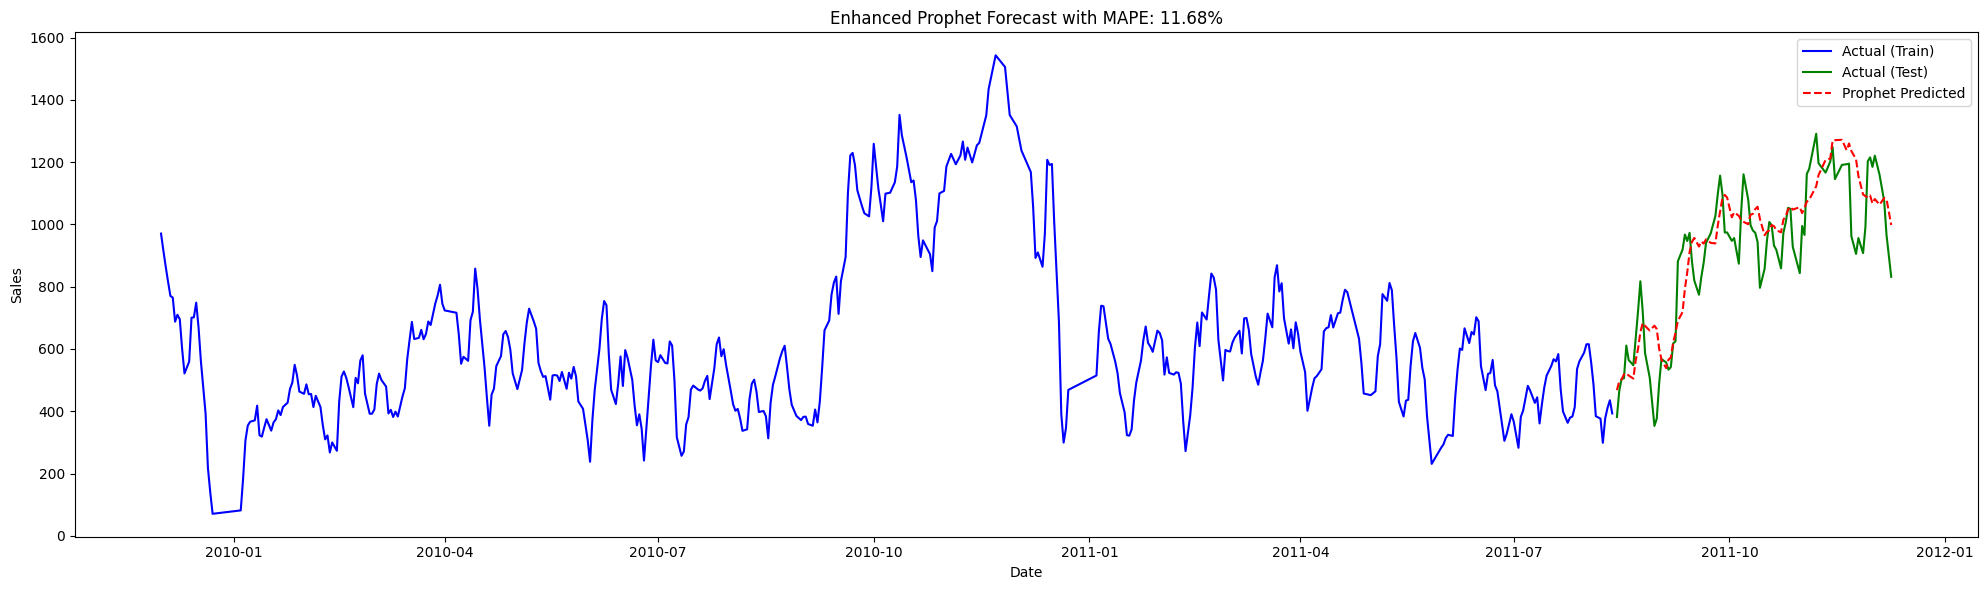


MAPE for Each Region:
  Region 1: 16.92%
  Region 2: 10.78%
  Region 3: 8.21%
  Region 4: 10.40%


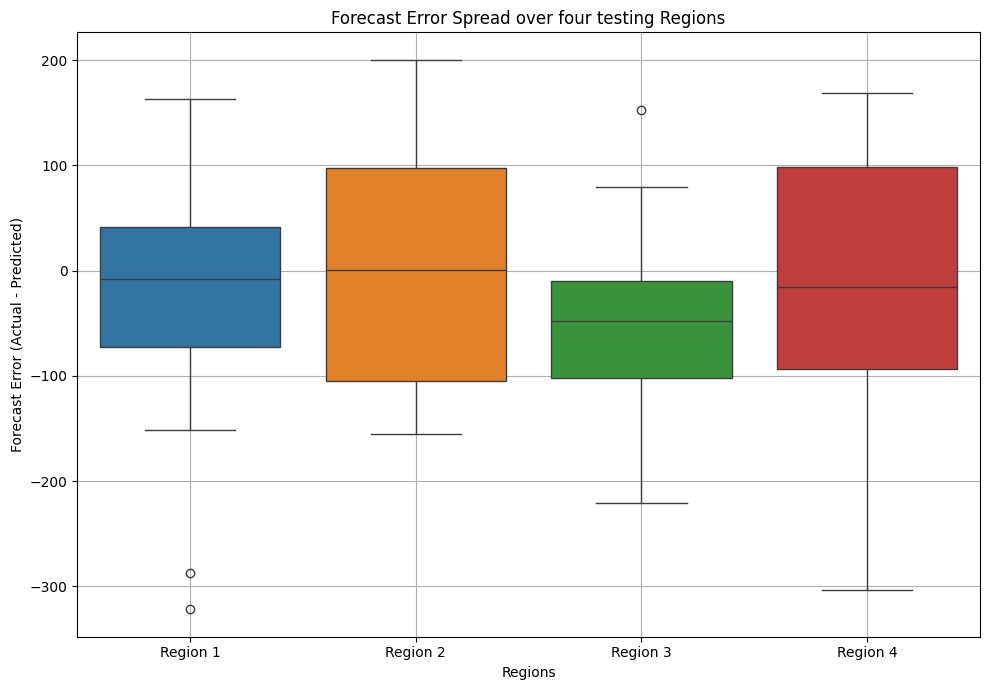


Best Hyperparameters: {'changepoint_prior_scale': 0.02, 'seasonality_mode': 'additive', 'fourier_order': 5}
Cross-Validated MAPE: 20.99%
Test MAPE: 11.68%


In [30]:
df = pd.read_csv("Cluster files//cluster_7.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.dropna(subset=['Quantity', 'Price'])
df['Sales'] = df['Quantity'] * df['Price']

# Aggregate daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

# Outlier removal
Q1, Q3 = daily_sales['y'].quantile([0.25, 0.75])
IQR = Q3 - Q1
daily_sales = daily_sales[(daily_sales['y'] >= (Q1 - 1.5 * IQR)) & (daily_sales['y'] <= (Q3 + 1.5 * IQR))]

# Savitzky-Golay smoothing
daily_sales['y'] = savgol_filter(daily_sales['y'], window_length=9, polyorder=2)

# Feature engineering
daily_sales['month'] = daily_sales['ds'].dt.month
daily_sales['day_of_week'] = daily_sales['ds'].dt.dayofweek
daily_sales['rolling_7'] = daily_sales['y'].rolling(7).mean().fillna(method='bfill')

# Add logistic growth boundaries
daily_sales['cap'] = daily_sales['y'].max() * 1.1
daily_sales['floor'] = daily_sales['y'].min() * 0.9

# Add US holiday dates
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=daily_sales['ds'].min(), end=daily_sales['ds'].max())
holidays_df = pd.DataFrame({'ds': holidays, 'holiday': 'us_holiday'})

# ------------------- Train/Test Split -------------------
test_size = 90
train_data = daily_sales.iloc[:-test_size].copy()
test_data = daily_sales.iloc[-test_size:].copy()

# ------------------- Hyperparameter Tuning -------------------
param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.02],
    'seasonality_mode': ['additive'],
    'fourier_order': [5, 8]
}

def tune_prophet_with_cv(train_data, param_grid):
    best_mape = np.inf
    best_model = None
    best_params = None

    for cps in param_grid['changepoint_prior_scale']:
        for sm in param_grid['seasonality_mode']:
            for fourier in param_grid['fourier_order']:
                try:
                    m = Prophet(
                        growth='logistic',
                        daily_seasonality=True,
                        changepoint_prior_scale=cps,
                        seasonality_mode=sm,
                        holidays=holidays_df
                    )
                    m.add_seasonality(name='yearly', period=365, fourier_order=fourier)
                    m.add_regressor('month')
                    m.add_regressor('day_of_week')
                    m.add_regressor('rolling_7')

                    m.fit(train_data)

                    df_cv = cross_validation(m, initial='450 days', period='45 days', horizon='90 days')
                    df_p = performance_metrics(df_cv, metrics=['mape'])
                    current_mape = df_p['mape'].mean() * 100

                    if current_mape < best_mape:
                        best_mape = current_mape
                        best_model = m
                        best_params = {
                            'changepoint_prior_scale': cps,
                            'seasonality_mode': sm,
                            'fourier_order': fourier
                        }
                except:
                    continue

    return best_model, best_params, best_mape

# Train best model
best_model, best_params, best_cv_mape = tune_prophet_with_cv(train_data, param_grid)

# ------------------- Forecasting -------------------
test_data['month'] = test_data['ds'].dt.month
test_data['day_of_week'] = test_data['ds'].dt.dayofweek
test_data['rolling_7'] = test_data['y'].rolling(7).mean().fillna(method='bfill')
test_data['cap'] = train_data['cap'].max()
test_data['floor'] = train_data['floor'].min()

future = test_data[['ds', 'month', 'day_of_week', 'rolling_7', 'cap', 'floor']]
forecast = best_model.predict(future)

y_true = test_data['y'].values
y_pred = forecast['yhat'].values
final_mape = mean_absolute_percentage_error(y_true, y_pred) * 100

# ------------------- Forecast Plot -------------------
plt.figure(figsize=(20, 6))
plt.plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='blue')
plt.plot(test_data['ds'], test_data['y'], label='Actual (Test)', color='green')
plt.plot(test_data['ds'], forecast['yhat'], label='Prophet Predicted', color='red', linestyle='--')
plt.title(f"Enhanced Prophet Forecast with MAPE: {final_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- Region-wise Boxplot -------------------
regions = 4
days_per_region = test_size // regions
error_lists = []

print("\nMAPE for Each Region:")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region
    y_true_region = y_true[start:end]
    y_pred_region = y_pred[start:end]
    region_errors = y_true_region - y_pred_region
    error_lists.append(region_errors)

    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

plt.figure(figsize=(10, 7))
sns.boxplot(data=error_lists)
plt.title("Forecast Error Spread over four testing Regions")
plt.xlabel("Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------- Summary -------------------
print(f"\nBest Hyperparameters: {best_params}")
print(f"Cross-Validated MAPE: {best_cv_mape:.2f}%")
print(f"Test MAPE: {final_mape:.2f}%")

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0877 - val_loss: 0.0080 - learning_rate: 3.0000e-04
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 998ms/step - loss: 0.0277 - val_loss: 0.0247 - learning_rate: 3.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 684ms/step - loss: 0.0143 - val_loss: 0.0067 - learning_rate: 3.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - loss: 0.0110 - val_loss: 0.0082 - learning_rate: 3.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 694ms/step - loss: 0.0093 - val_loss: 0.0071 - learning_rate: 3.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 690ms/step - loss: 0.0076 - val_loss: 0.0076 - learning_rate: 3.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 670ms/step - loss: 0.0080 - val_loss: 0.0066 - learning_rate: 3.0000e-04
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - loss: 0.0065 - val_loss: 0.0060 - learning_rate: 3.0000e-04
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - loss: 0.0063 - val_loss: 0.0052 - learning_rate: 3.000

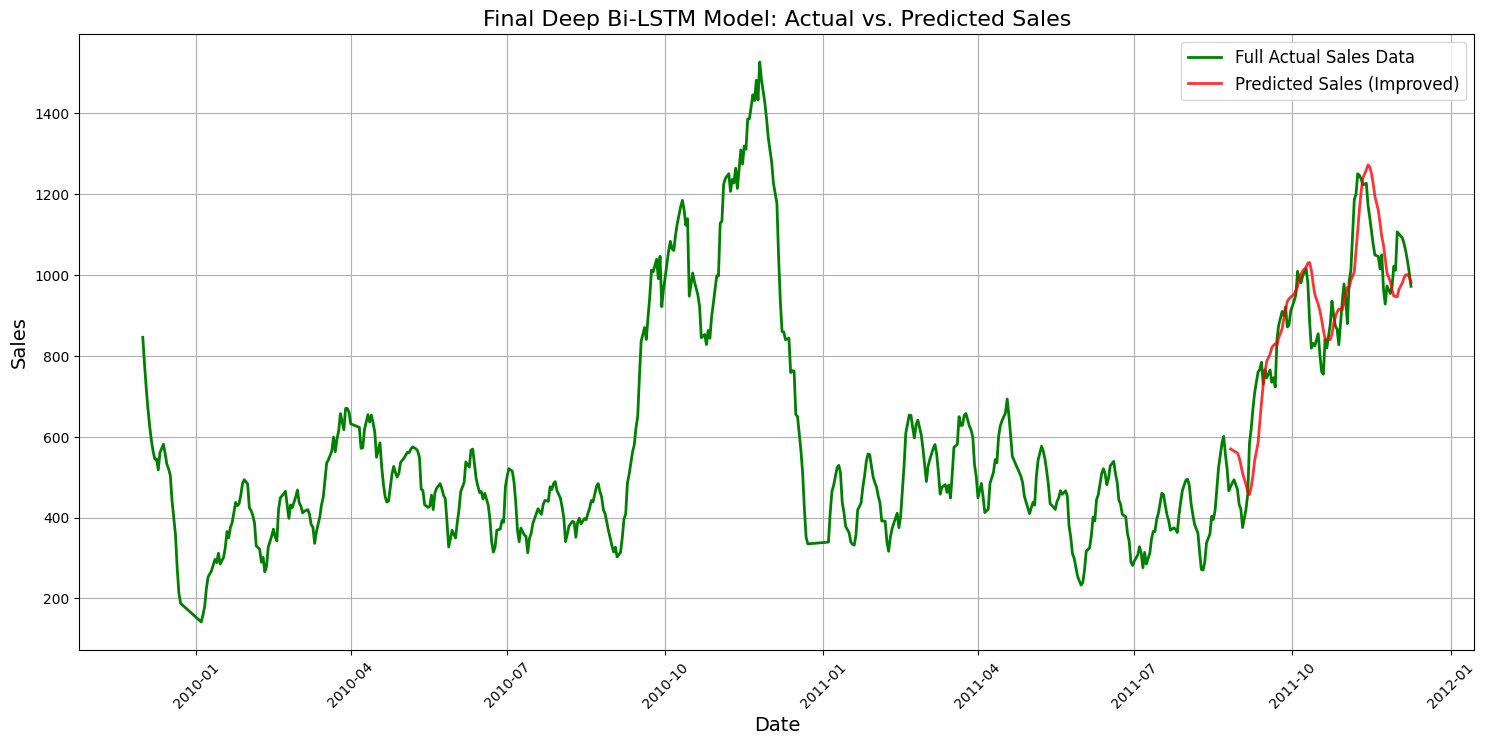

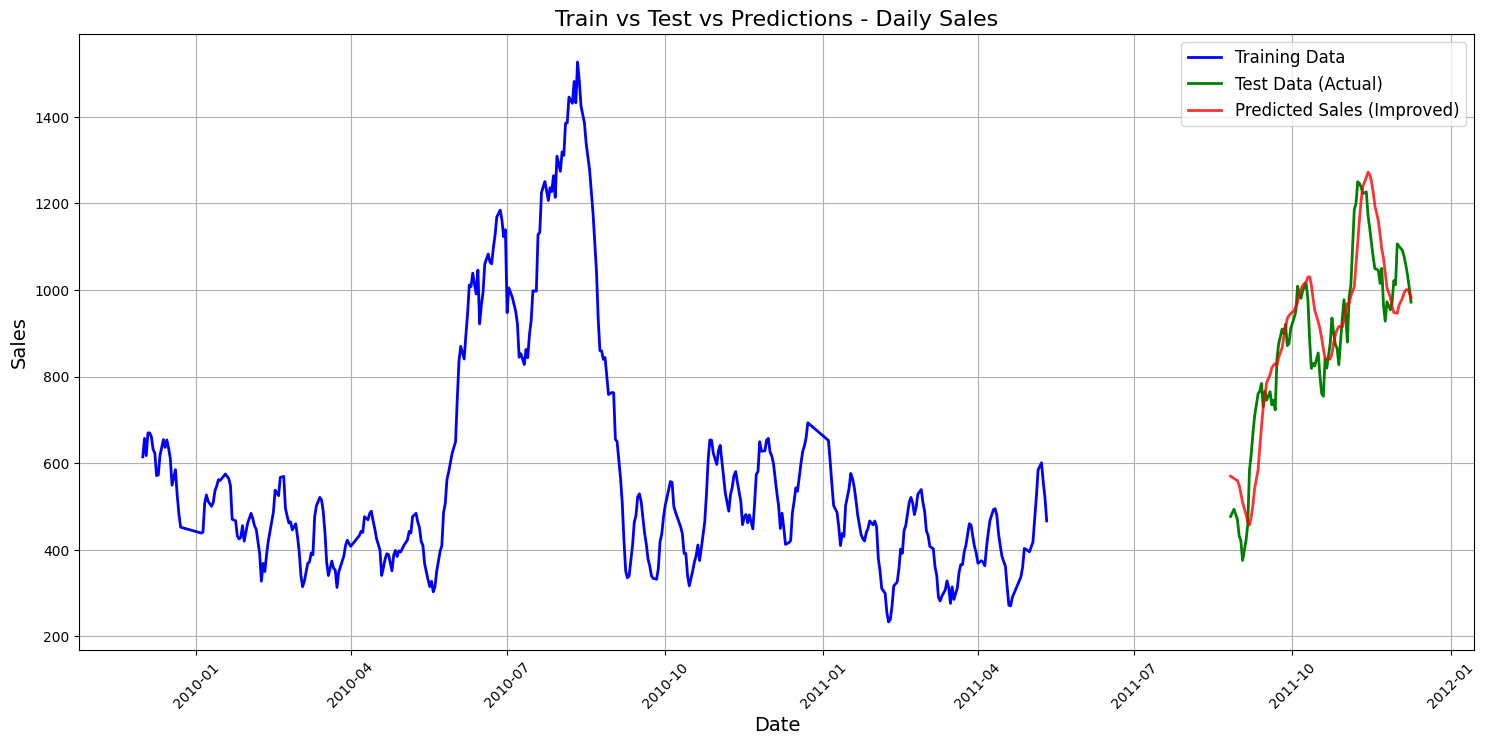

MAPE for Each Region (LSTM Model):
Region 1: 16.02%
Region 2: 6.42%
Region 3: 6.30%
Region 4: 8.50%


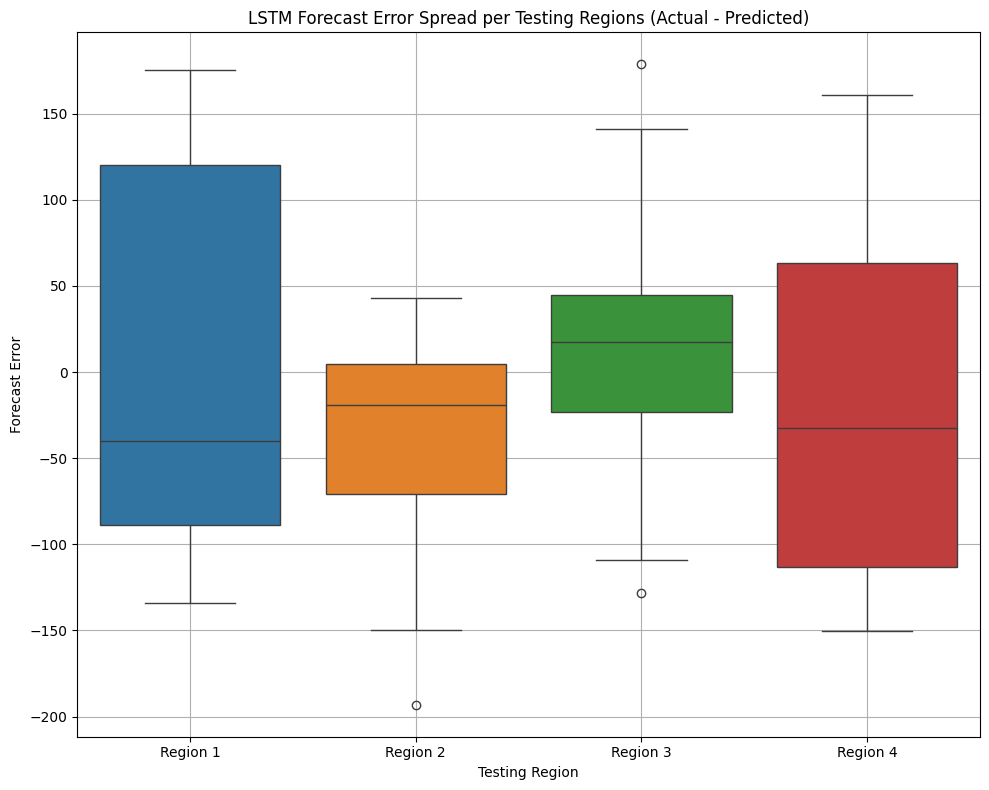

In [22]:
df = pd.read_csv("Cluster files//cluster_7.csv")  # Change to actual dataset file

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# *Step 2: Pre-Processing*
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]  # Remove Refunds (Negative Sales)
df['Sales'] = df['Quantity'] * df['Price']  # Compute Total Sales

# Remove Outliers using IQR Method
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sales'] >= (Q1 - 1.5 * IQR)) & (df['Sales'] <= (Q3 + 1.5 * IQR))]

# Aggregate Sales Data by Date
daily_sales_lstm = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum().reset_index()
daily_sales_lstm.columns = ['ds', 'y']
daily_sales_lstm['ds'] = pd.to_datetime(daily_sales_lstm['ds'])

# Apply Savitzky-Golay Smoothing (Window Size: 15, Polynomial Order: 2)
daily_sales_lstm['y'] = savgol_filter(daily_sales_lstm['y'], window_length=15, polyorder=2)

# Normalize sales values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
daily_sales_lstm['y'] = scaler.fit_transform(daily_sales_lstm[['y']])

# *Step 3: Function to Create Sequences*
def create_sequences(data, time_steps=90):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array
sales_data = daily_sales_lstm[['y']].values

# Define sequence length (look-back period)
time_steps = 90  # 90 days lookback

# Generate sequences
X, y = create_sequences(sales_data, time_steps)

# Reshape X to fit LSTM input requirements
X = X.reshape((X.shape[0], X.shape[1], 1))

# *Step 4: Train-Test Split (Last 90 Days for Testing)*
test_size = 90  # Use last 90 days for testing
train_size = len(X) - test_size  # Everything before the last 90 days is training data

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# *Step 5: Optimized Bi-LSTM Model*
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(time_steps, 1)),
    Dropout(0.15),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
    Dropout(0.15),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(1, activation="linear")
])

# *Step 6: Optimized Learning Rate & Regularization*
optimizer = Adam(learning_rate=0.0003)  # Lower learning rate for stability

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# *Step 7: Implement Early Stopping & Learning Rate Scheduler*
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00005)

# Train model
history = model.fit(X_train, y_train,
                    epochs = 20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_reduction],
                    verbose=1)

# *Step 8: Predict on Test Data*
y_pred = model.predict(X_test)

# *Step 9: Fix Shape Mismatch*
y_pred = y_pred[:len(y_test)]  # Ensure predictions match test set length

# *Step 10: Reverse Scaling*
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# *Step 11: Compute Error Metrics*
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
accuracy = 100 - mape

# Print Metrics
print(f"MAPE: {mape:.2f}%")

# *Step 12: Plot Optimized Predictions with Actual Dates*
plt.figure(figsize=(18,8))

# Extract proper date range for test data
date_range = daily_sales_lstm['ds'].iloc[-len(y_test_original):]

# Plot full actual sales data
plt.plot(daily_sales_lstm['ds'], scaler.inverse_transform(daily_sales_lstm[['y']]),
         label="Full Actual Sales Data", color='g', linewidth=2)

# Plot predictions on test set
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Final Deep Bi-LSTM Model: Actual vs. Predicted Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# *Step 13: Train vs Test vs Predictions*
plt.figure(figsize=(18,8))

# Training Data
plt.plot(daily_sales_lstm['ds'][:len(y_train)], scaler.inverse_transform(y_train.reshape(-1,1)),
         label="Training Data", color='blue', linewidth=2)

# Test Data
plt.plot(date_range, y_test_original, label="Test Data (Actual)", color='g', linewidth=2)

# Predictions
plt.plot(date_range, y_pred_original, label="Predicted Sales (Improved)", color='r', linewidth=2, alpha=0.8)

# *Proper X-Axis Labeling with Dates*
plt.xlabel("Date", fontsize=14)
plt.xticks(rotation=45)  # Rotate for better readability
plt.ylabel("Sales", fontsize=14)
plt.title("Train vs Test vs Predictions - Daily Sales", fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()


regions = 4
days_per_region = 90 // regions  # 90 test days divided into 5 regions
lstm_mape_list = []
lstm_error_lists = []

print("MAPE for Each Region (LSTM Model):")
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = y_test_original[start:end].flatten()  # Convert to 1D array
    y_pred_region = y_pred_original[start:end].flatten()  # Convert to 1D array

    mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    lstm_mape_list.append(mape)
    lstm_error_lists.append(list(y_true_region - y_pred_region))  # Ensure it's a 1D list

    print(f"Region {i+1}: {mape:.2f}%")

plt.figure(figsize=(10, 8))
sns.boxplot(data=lstm_error_lists)
plt.title("LSTM Forecast Error Spread per Testing Regions (Actual - Predicted)")
plt.xlabel("Testing Region")
plt.ylabel("Forecast Error")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

GLM MAPE: 13.571006506366132 %


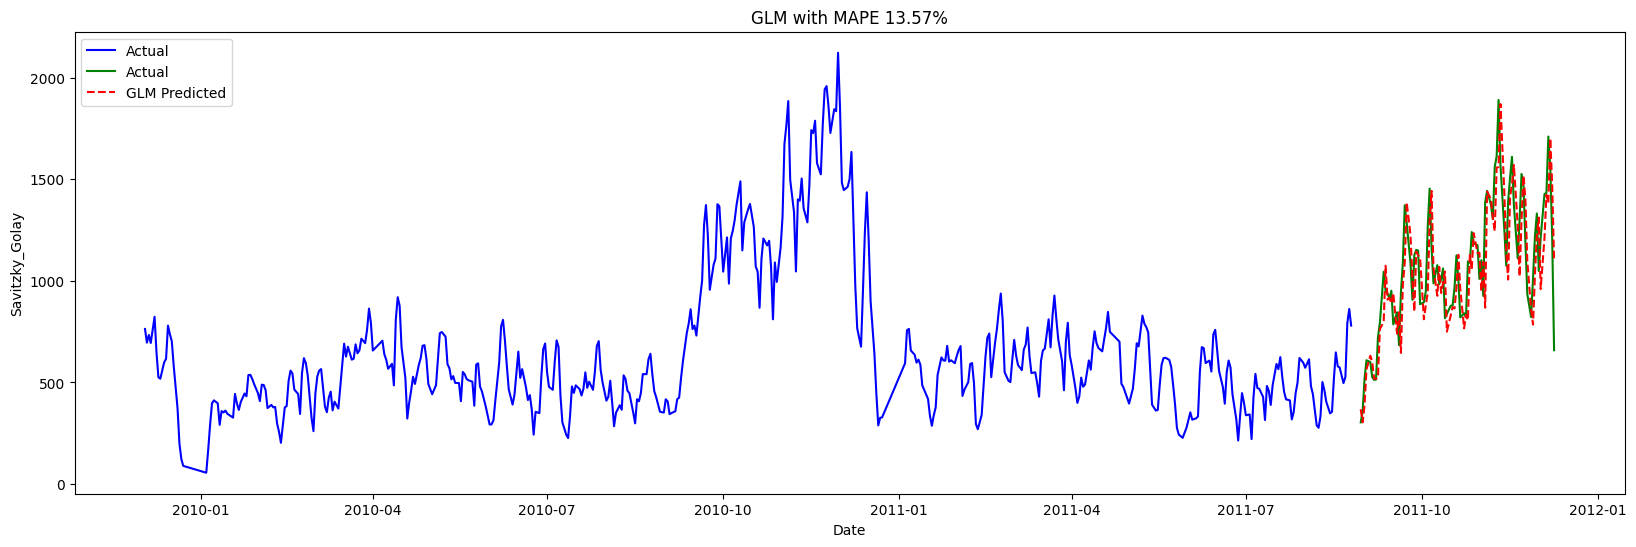

  Region 1: 13.37%
  Region 2: 12.22%
  Region 3: 11.71%
  Region 4: 16.99%


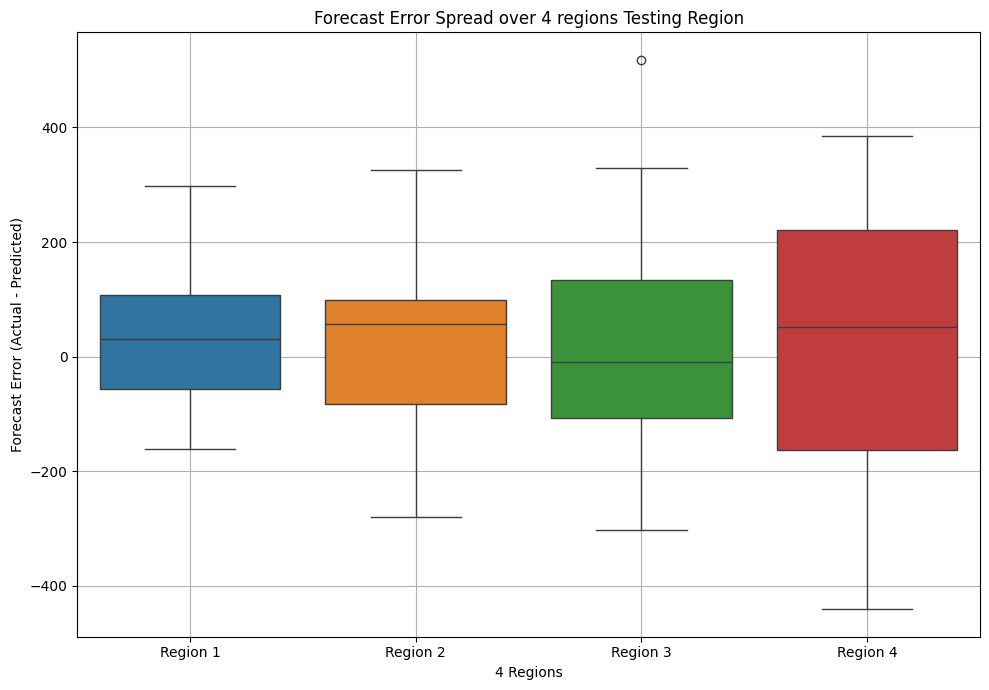

In [23]:
import pandas as pd
cluster_data = pd.read_csv("Cluster files//cluster_7.csv")
cluster_data
# Assuming the data is stored in a DataFrame called `df`
# Convert InvoiceDate to datetime format
cluster_data['InvoiceDate'] = pd.to_datetime(cluster_data['InvoiceDate'])

# Extract the date part
cluster_data['Date'] = cluster_data['InvoiceDate'].dt.date

# Calculate total sales for each transaction
cluster_data['TotalSales'] = cluster_data['Quantity'] * cluster_data['Price']

# Aggregate total sales by date
sales_by_date = cluster_data.groupby('Date')['TotalSales'].sum().reset_index()

# Rename columns for clarity
sales_by_date.columns = ['Date', 'TotalSales']

# Display the result
daily_sales = sales_by_date.copy()
# Resetting Date as index
df_daily = pd.DataFrame(daily_sales)
df_daily['Savitzky_Golay'] = savgol_filter(df_daily['TotalSales'], window_length=7, polyorder=2)
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.set_index('Date', inplace=True)
test_size = 90
train = df_daily.iloc[:-test_size]
test = df_daily.iloc[-test_size:]
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Split into train (all but last 30 days) and test (last 30 days)
test_size = 90
X_train = daily_sales.iloc[:-test_size]
y_train = daily_sales.iloc[-test_size:]

# Create lagged features
train['Lag1'] = train['Savitzky_Golay'].shift(1)
train['Lag2'] = train['Savitzky_Golay'].shift(2)
train.dropna(inplace=True)

# Prepare data for GLM
X_train = add_constant(train[['Lag1', 'Lag2']])
y_train = train['Savitzky_Golay']

# Fit GLM model
# glm_model = GLM(y_train, X_train, family=sm.families.Gaussian()).fit()
glm_model = GLM(y_train, X_train, family=sm.families.Gaussian(), alpha=0.1).fit()

# Create lagged features for test data
test['Lag1'] = test['Savitzky_Golay'].shift(1)
test['Lag2'] = test['Savitzky_Golay'].shift(2)
test.dropna(inplace=True)

# Predict for the test period
X_test = add_constant(test[['Lag1', 'Lag2']])
glm_pred = glm_model.predict(X_test)

# Calculate MAPE
glm_mape = mean_absolute_percentage_error(test['Savitzky_Golay'], glm_pred) * 100
print("GLM MAPE:", glm_mape, "%")
plt.figure(figsize=(20, 6))
plt.plot(train['Date'], train['Savitzky_Golay'], label='Actual', color='blue')
plt.plot(test['Date'], test['Savitzky_Golay'], label='Actual', color='green')
plt.plot(test['Date'], glm_pred, label='GLM Predicted', color='red', linestyle='--')
plt.title(f"GLM with MAPE {glm_mape:.2f}%")
plt.xlabel('Date')
plt.ylabel('Savitzky_Golay')
plt.legend()
plt.show()

# Parameters
regions = 4
days_per_region = len(test) // regions  # Ensure it's divided properly, e.g., should be 15 if len(test) == 90

# Compute error (Actual - Predicted) per region
error_lists = []
for i in range(regions):
    start = i * days_per_region
    end = (i + 1) * days_per_region

    y_true_region = test['Savitzky_Golay'].iloc[start:end]
    y_pred_region = glm_pred[start:end]
    errors = y_true_region - y_pred_region
    error_lists.append(errors)
    region_mape = mean_absolute_percentage_error(y_true_region, y_pred_region) * 100
    print(f"  Region {i+1}: {region_mape:.2f}%")

# Convert error_lists to DataFrame for easier plotting with Seaborn
error_df = pd.DataFrame(error_lists).T  # Transpose to make each region a column

# Plotting
plt.figure(figsize=(10, 7))
sns.boxplot(data=error_df)
plt.title("Forecast Error Spread over 4 regions Testing Region")
plt.xlabel("4 Regions")
plt.ylabel("Forecast Error (Actual - Predicted)")
plt.xticks(ticks=range(regions), labels=[f"Region {i+1}" for i in range(regions)])
plt.grid(True)
plt.tight_layout()
plt.show()

